# 1. Loading Dependencies

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# 2. Loading Processed Data

In [2]:
df = pd.read_csv('/Users/mayankahuja/Desktop/Cardora/data/processed_data.csv')
print('CSV imported successfully.')

CSV imported successfully.


# 3. Choosing the Target Variable

The target variable is set as `bill_amt1`, which represents the **next month’s billing amount** for a customer.  
This variable is chosen because it directly reflects short-term financial activity and helps identify spending or repayment trends.

Selecting this target allows the model to learn patterns that predict how much a customer is likely to owe next month.  
Such predictions can assist credit analysts in identifying customers at risk of overspending or requiring credit adjustments.

If an irrelevant or indirect variable were chosen as the target, the model’s predictions would lose business meaning and accuracy, making the results difficult to interpret or apply.


In [3]:
TARGET = 'bill_amt1'
feature_cols = [
    'limit_bal', 'age', 'avg_bill_amt_6m', 'total_pay_amt_6m'
]

# 4. Preparing `X` and `y`

Preparing `X` and `y` means splitting the dataset into two parts — the input features and the target variable.  
`X` contains the independent variables (such as credit limit, bill amounts, and payment history), while `y` represents the value that needs to be predicted.

This is done to clearly tell the model what information should be used for learning (`X`) and what outcome it should try to predict (`y`).  
In this project, the model is trained to estimate a customer’s **next month’s bill amount** based on their previous financial behavior.

If this separation is not done properly, the model may unintentionally use future or dependent data to make predictions, leading to **data leakage** and unrealistically high accuracy that would fail in real-world scenarios.


In [4]:
X = df[feature_cols].fillna(0)   # ensure no nans
y = df[TARGET].fillna(0)

# 5. Train/Test Split

Splitting the dataset into training and testing subsets is a fundamental step in model development.
The training set is used to teach the model the underlying relationships in the data, while the test set is reserved to evaluate how well the model generalizes to unseen information.

This is done to ensure that the model’s performance reflects real-world predictive ability and not just memorization of the training examples.
Typically, around 70–80% of the data is used for training and the remaining 20–30% for testing.

If this step were skipped, it would be impossible to gauge the model’s reliability on new data — leading to overconfidence in its performance and potential business risk if deployed.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Baseline Pipeline

The features are first standardized using StandardScaler().
This step adjusts all input variables to have a similar range and distribution, ensuring that features with large values (like credit limit) don’t overpower smaller-valued features (like payment delays).

After scaling, a Linear Regression model is trained on the training dataset. This model tries to find the best-fitting straight line that connects our input features (X) with the target variable (y).


In [22]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test_scaled)


# 7. Metrics

Once the model is trained, its accuracy and reliability are checked using standard regression metrics:

- `R² Score`: Explains how much of the variation in the target variable (bill amount) is captured by the model.
- `RMSE (Root Mean Squared Error)`: Measures the average difference between predicted and actual values — lower means better predictions.
- `MAE (Mean Absolute Error)`: Shows how far off predictions are on average, regardless of direction.

These metrics together give a good snapshot of how well the linear model fits the data and how much error can be expected when making predictions on new customers.

In [15]:
# Calculate basic performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Linear Regression Results:
R² Score: 0.8957
RMSE: 24073.81
MAE: 12657.87


# 8. Diagnostics

To visually inspect how well the model performs, three diagnostic plots are used:

- `Residuals vs Predicted Values`: Checks if model errors (residuals) are randomly spread, confirming that the linear pattern fits well.

- `Feature Influence on Credit Utilization`: Illustrates which input features most strongly affect credit utilization, either positively or negatively. Features with larger absolute influence values have a greater impact on how much credit a user tends to utilize.

- `Actual vs Predicted Values`: Shows how close the model’s predictions are to real billing amounts.

Together, these diagnostics provide a quick visual validation that the model behaves as expected and that predictions are consistent with real-world credit utilization patterns.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

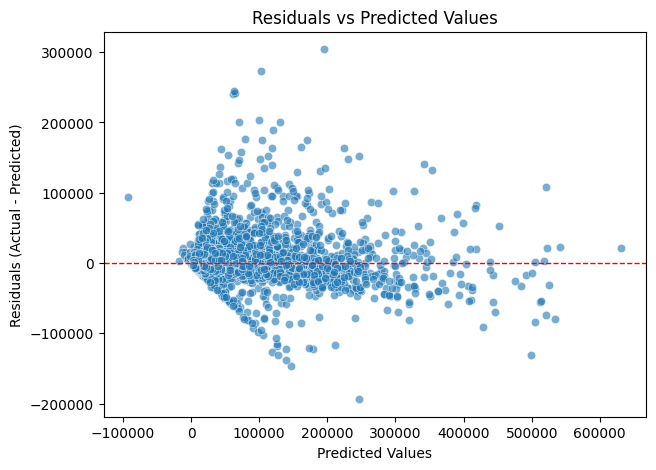

In [16]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=y_test - y_pred, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


## `A. Residuals vs Predicted Plot`
This plot helps assess whether the model’s errors are spread out randomly.
If the points are scattered evenly around zero (the red line), it means the model predicts fairly consistently across the range.
Here, the residuals appear roughly centered, suggesting that our linear model captures the trend well without major bias.

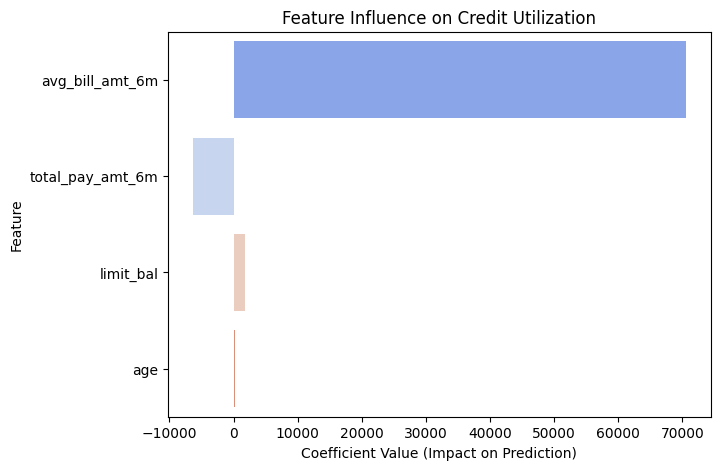

In [ ]:
importance = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x=importance.values, y=importance.index, hue=importance.index, palette="coolwarm")
plt.title("Feature Influence on Credit Utilization")
plt.xlabel("Coefficient Value (Impact on Prediction)")
plt.ylabel("Feature")
plt.show()

## `B. Feature Influence Plot`
This bar chart highlights which features most strongly influence the predicted bill amount.
Features with larger bars (in either direction) have a greater impact.
For instance, if LIMIT_BAL shows a positive coefficient, it means higher credit limits tend to be linked with higher billing amounts, resulting in a practical insight for credit planning.

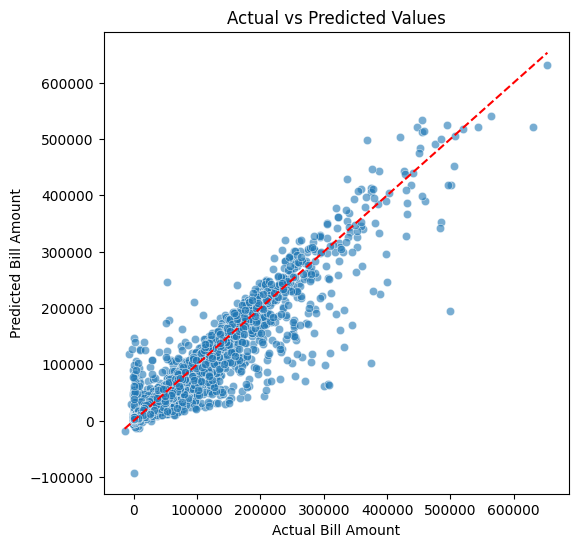

In [20]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Bill Amount")
plt.ylabel("Predicted Bill Amount")
plt.show()


## `C. Actual vs Predicted Plot`
A simple comparison of the model’s predictions against actual outcomes.
Ideally, points should cluster around the red diagonal line, meaning predictions are close to reality.
Here, we see a decent alignment, indicating that the model generalizes reasonably well to unseen data.